In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

In [10]:

def g(x):
    if x < -0.2:
        return 0 
    elif x <0.2:
        return 0.1 + x/2 
    elif x < 0.8:
        return x 
    elif x <= 1.2:
        return 0.4 + x/2
    else:
        return 1 


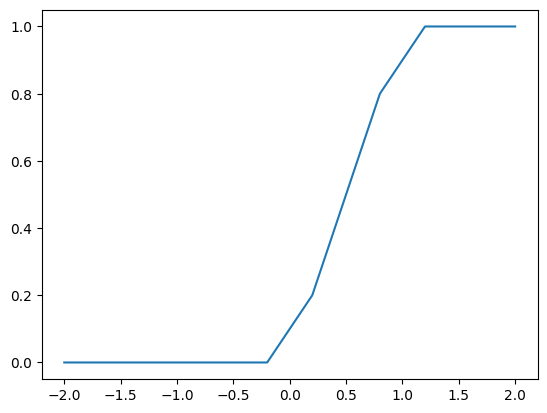

In [11]:
xs = np.linspace(-2,2,1000)
gs = np.zeros(1000)
for i in range(1000):
    gs[i] = g(xs[i])

plt.plot(xs,gs)

In [ ]:
# def f(x):
#     if x < -0.2:
#         return -x + 0.8 
#     elif x <0.2:
#         return - 0.75 * x + 0.85
#     elif x < 0.8:
#         return -x/2 + 0.8 
#     elif x <= 1.2:
#         return -0.75 *x + 1
#     else:
#         return -x + 1.3 

/tmp/ipykernel_134689/1108787575.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("nullclines.png")
/tmp/ipykernel_134689/1108787575.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("nullclines.png")
/tmp/ipykernel_134689/1108787575.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("nullclines.png")
/tmp/ipykernel_134689/1108787575.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("nullclines.png")


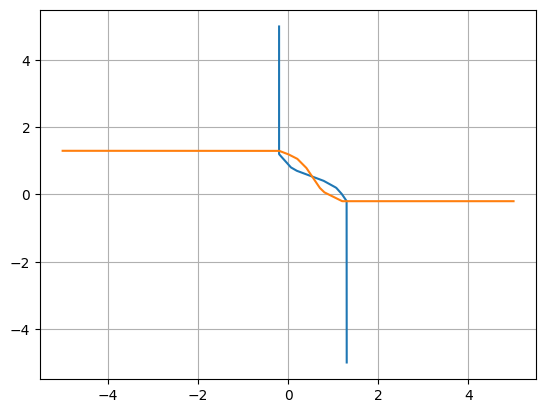

In [47]:
h2s = np.linspace(-5,5,1000)
h1s = np.zeros(1000) + 0 
steps = 100
b = 0.8
for _ in range(steps):
    for j in range(1000):
        h1_dot = - h1s[j] + 0.5 * g(h1s[j]) - g(h2s[j]) + b 
        h1s[j] += h1_dot

plt.plot(h1s,h2s)
plt.plot(h2s,h1s)
plt.grid()
plt.savefig("nullclines.png")




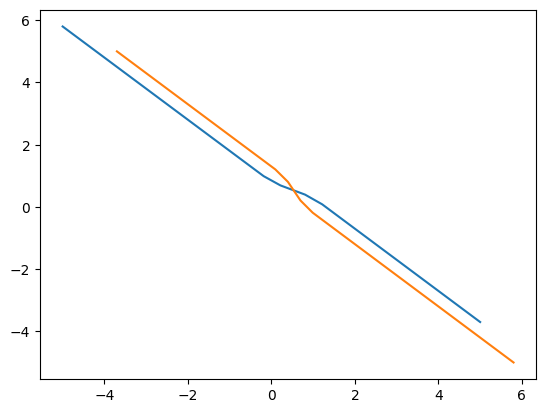

In [19]:
xs = np.linspace(-5,5,1000)
fs = np.zeros(1000)
for i in range(1000):
    fs[i] = f(xs[i])

plt.plot(xs,fs)
plt.plot(fs,xs)

In [91]:
import numpy as np 
import matplotlib.pyplot as plt 
import networkx as x
from numba import njit 
from tqdm import tqdm
import torch 

N = 100
K = 7.5 * N /3000
n_r = 6
R = 2/3 * 10**6
C = 30 * 10**-12
V_r = -70 * 10**-3
theta = -50 * 10**-3
w_e = 95 * 10**-12
w_in = 80 * 10**-12
p_r = 0.25
tau_rp = 1 * 10**-3
tau_s = 5 * 10**-3
tau_R = 0.1 


f = 1
dt = 0.0005
T = 10
time_steps = int(T / dt)

poisson_I= np.random.poisson(f * dt, (N, time_steps))



Graph = x.erdos_renyi_graph(N,K/N,seed=0,directed=False)
A = np.zeros((N,N))
B = x.adjacency_matrix(Graph) 
for edge in list(Graph.edges):
    A[edge[0],edge[1]] = +1 



t_span = np.tile(np.arange(0,T,dt).reshape((-1,1)),N).T
t_span.shape


(100, 20000)

In [ ]:

@njit
def get_I_ext(t):
    I_ext = np.zeros(N)
    step = int(t/dt)
    fired = np.zeros((N,time_steps))
    fired[:,:step] = (poisson_I != 0 )[:,:step]
    return np.sum((np.exp((-(t - t_span*poisson_I)/tau_s) * fired) * fired),axis = 1)








@njit
def get_I_in(t,U,spikes):
    step = int(t/dt)
    internal = np.zeros(N)
    opening = p_r * (U * spikes.reshape((N,time_steps,1)))
    eta = np.random.uniform(0,1,opening.shape)

    fired = np.zeros((N,time_steps))
    fired[:,:step] = (spikes != 0 )[:,:step]
    gate = np.sum(np.exp((-(t - t_span*spikes)/tau_s) * fired) * fired * heaviside(opening - eta ).sum(2),axis = 1 )
    return A @  gate


@njit
def U_dot(t,U,spikes):
    U_dot = np.zeros((N,6))
    step = int(t/dt)
    opening = spikes[:,step].copy().reshape((-1,1))
    eta = np.random.uniform(0,1,(N,n_r))
    U_dot = (1- U[:,step])/tau_R - ((heaviside(p_r - eta ) * opening) * U[:,step]) 
    return U_dot




@njit
def heaviside(x):
    return np.where(x > 0 , 1 , 0)


@njit
def V_dot(V,t,U):
    return  -(V - V_r)/(R*C) + get_I_ext(t)/C + get_I_in(t,U,spikes)/C 




spikes = np.zeros((N,time_steps))
U = np.ones((N,time_steps,n_r))
V = np.zeros(N)


Sleep = np.zeros(N)
Switch = Sleep == 0 

    




for step in tqdm(range(time_steps)):
    Sleep += -((Sleep != 0) * dt) 
    t = step * dt

    dU = U_dot(t,U,spikes)*dt
    dV = V_dot(V,t,U)*dt

    U[:,step+1,:] += dU 
    V += dV * Switch

    is_spike = V > theta
    V = np.where(V> theta , V_r, V)
    spikes[:,step+1] =  is_spike

    Sleep += tau_rp * is_spike
    Switch = Sleep == 0 
    # if np.any(is_spike): print("spike :) ")



  0%|          | 30/20000 [00:15<2:48:27,  1.98it/s]


KeyboardInterrupt: 

In [20]:
# print("num spikes : ", torch.sum(spikes))

# plt.imshow(spikes[:,:1000])

# plt.plot(torch.arange(time_steps)[:],spikes.sum(0)[:])

torch.mean(spikes)

tensor(0.1682)

In [22]:
spikes = torch.load("spikes (6).pt",map_location=torch.device('cpu'))

num spikes :  tensor(3210516.)


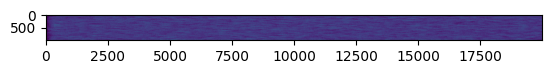

tensor(160.5258)


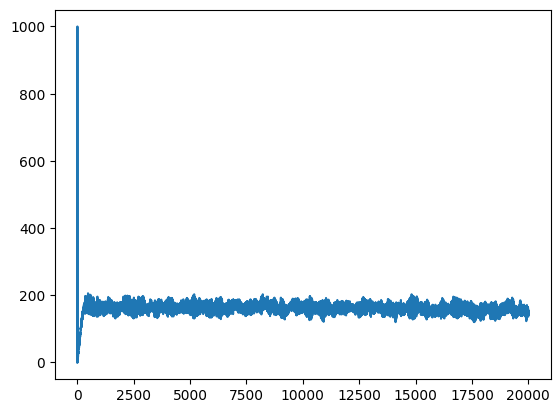

In [24]:
print("num spikes : ", torch.sum(spikes).cpu())

plt.imshow(spikes[:,:20000].cpu())
plt.show()
plt.plot(torch.arange(20000)[:],spikes.sum(0)[:].cpu())

print(spikes.sum(0).mean().cpu())

In [28]:
poisson_I

NameError: name 'poisson_I' is not defined

In [25]:
avalanch = spikes.sum(0) != 0
slippingR = avalanch.roll(+1)
slippingL = avalanch.roll(-1)
slippingR[0] = False
slippingL[-1] = False

ends  = torch.logical_xor( avalanch ,(avalanch *slippingL))
starts  = torch.logical_xor( avalanch ,(avalanch *slippingR))

avalanches_size = torch.where(ends) [0] -   torch.where(starts)[0] + 1


In [26]:
avalanches_size,ends.sum(),starts.sum()

(tensor([    1,     1, 19993]), tensor(3), tensor(3))

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 array([1.00000e+00, 2.00020e+03, 3.99940e+03, 5.99860e+03, 7.99780e+03,
        9.99700e+03, 1.19962e+04, 1.39954e+04, 1.59946e+04, 1.79938e+04,
        1.99930e+04]),
 <a list of 3 BarContainer objects>)

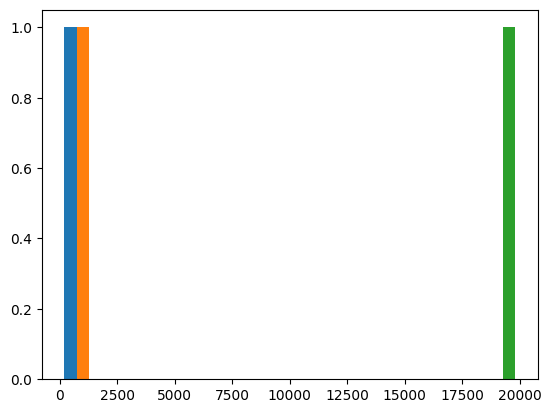

In [27]:

plt.hist(avalanches_size)


/tmp/ipykernel_241501/2736263507.py:2: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))


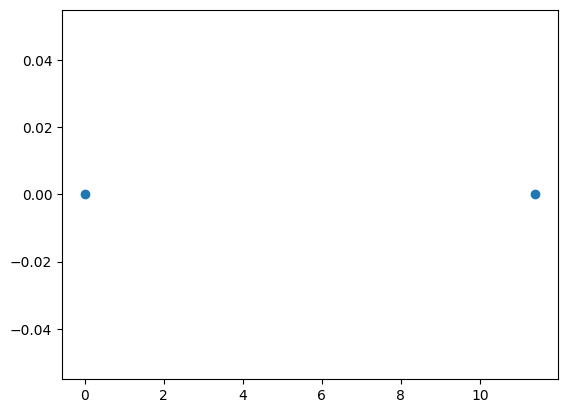

In [13]:


freq,size = np.histogram(avalanches_size.cpu())
plt.scatter(np.log(size[:-1]),np.log(freq))

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import networkx as x
from numba import njit 
from tqdm import tqdm
import torch 

N = 100
K = 7.5 * N /3000
n_r = 6
R = 2/3 * 10**6
C = 30 * 10**-12
V_r = -70 * 10**-3
theta = -50 * 10**-3
w_e = 95 * 10**-12
w_in = 80 * 10**-12
p_r = 0.25
tau_rp = 1 * 10**-3
tau_s = 5 * 10**-3
tau_R = 0.1 


f = 1
dt = 0.0005
T = 10
time_steps = int(T / dt)

device = "cuda"

poisson_I= torch.tensor(np.random.poisson(f * dt, (N, time_steps)),device=device)

spikes = torch.zeros((N,time_steps),device=device)
U = torch.ones((N,time_steps,n_r),device=device)
V = torch.zeros(N,device=device)


Sleep = torch.zeros(N,device=device)
Switch = Sleep == 0 




Graph = x.erdos_renyi_graph(N,K/N,seed=0,directed=False)
A = torch.zeros((N,N),device=device)
B = x.adjacency_matrix(Graph) 
for edge in list(Graph.edges):
    A[edge[0],edge[1]] = +1 


t_span = torch.tile(torch.arange(0,T,dt,device = device),(N,1))
def get_I_ext(t):
    I_ext = torch.zeros(N,device=device)
    step = int(t/dt)
    fired = torch.zeros((N,time_steps),device=device)
    fired[:,:step] = (poisson_I != 0 )[:,:step]
    return torch.sum((torch.exp((-(t - t_span*poisson_I)/tau_s) * fired) * fired),dim = 1)


def get_I_in(t,U,spikes):
    step = int(t/dt)
    internal = torch.zeros(N,device=device)
    opening = p_r * (U * spikes.reshape((N,time_steps,1)))
    eta = torch.rand(opening.shape,device=device)

    fired = torch.zeros((N,time_steps),device=device)
    fired[:,:step] = (spikes != 0 )[:,:step]
    gate = torch.sum(torch.exp((-(t - t_span*spikes)/tau_s) * fired) * fired * torch.heaviside(opening - eta ,torch.zeros_like(eta,device=device)).sum(2),dim = 1 )
    return A @  gate


def V_dot(V,t,U):
    return  -(V - V_r)/(R*C) + get_I_ext(t)/C + get_I_in(t,U,spikes)/C 



def U_dot(t,U,spikes):
    U_dot = torch.zeros((N,6),device=device)
    step = int(t/dt)
    opening = spikes[:,step].reshape((-1,1))
    eta = torch.rand((N,n_r))
    U_dot = (1- U[:,step])/tau_R - ((torch.heaviside(p_r - eta ,torch.zeros_like(eta,device=device)) * opening) * U[:,step]) 
    return U_dot



for step in tqdm(range(time_steps)):
    Sleep += -((Sleep != 0) * dt) 
    t = step * dt

    dU = U_dot(t,U,spikes)*dt
    dV = V_dot(V,t,U)*dt

    U[:,step+1,:] += dU 
    V += dV * Switch

    is_spike = V > theta
    V = torch.where(V> theta , V_r, V)
    spikes[:,step+1] =  is_spike

    Sleep += tau_rp * is_spike
    Switch = Sleep == 0 
    # if np.any(is_spike): print("spike :) ")





RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [13]:
V_dot(V,0,U)

tensor([-3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500.,
        -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500.,
        -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500.,
        -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500.,
        -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500.,
        -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500.,
        -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500.,
        -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500.,
        -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500.,
        -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500.,
        -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500., -3500.,
        -3500.])

  0%|          | 25/20000 [00:06<1:32:36,  3.59it/s]


KeyboardInterrupt: 